In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

load_dotenv()

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F


# Emb. Model & Tokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained(
    "nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True
)
model.eval()
model = model.to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def get_text_embeddings(text, norm=False):
    """
    Gets the text embeddings for the given text.

    Args:
        text (str): The text to get embeddings for.

    Returns:
        list: The text embeddings as a list.
    """
    encoded_input = tokenizer(
        [text], padding=True, truncation=True, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)

    embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    if norm:
        embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.cpu().squeeze(0).numpy().tolist()

<All keys matched successfully>


# Vector Database

In [3]:
import chromadb

chroma_client = chromadb.PersistentClient("db/")
collection = chroma_client.get_or_create_collection(
    name="emotions_cosine", metadata={"hnsw:space": "cosine"}
)

In [4]:
definitions = {
"admiration": "Finding something praiseworthy or deserving of utmost respect.",
"amusement": "Experiencing a sense of delight or being entertained by something humorous.",
"anger": "A powerful feeling of displeasure, hostility, or indignation.",
"annoyance": "A mild form of vexation or irritation.",
"approval": "Expressing a favorable judgment and recognizing its correctness.",
"caring": "Exhibiting kindness, compassion, and concern for the well-being of others.",
"confusion": "A state of perplexity, uncertainty, or lack of comprehension.",
"curiosity": "An intense eagerness to acquire knowledge or uncover something new.",
"desire": "A powerful longing or craving for something or a wish for a particular outcome.",
"disappointment": "A feeling of dissatisfaction or sadness due to unmet hopes or expectations.",
"disapproval": "Expressing disagreement, objection, and regarding something as unacceptable or inadequate.",
"disgust": "A strong aversion or revulsion towards something deemed offensive or repugnant.",
"embarrassment": "A feeling of self-consciousness, awkwardness, or discomfort in a particular situation.",
"excitement": "A state of heightened enthusiasm, eagerness, or exhilaration.",
"fear": "Experiencing a sense of apprehension, dread, or worry.",
"gratitude": "A feeling of thankfulness, appreciation, or indebtedness.",
"grief": "Profound sorrow or anguish, especially caused by the loss of a loved one.",
"joy": "A state of profound delight, happiness, or elation.",
"love": "A deep and tender affection or fondness for someone or something.",
"nervousness": "A state of unease, apprehension, or anxiety.",
"optimism": "A positive and hopeful outlook, expecting the best possible outcome.",
"pride": "A feeling of self-respect, dignity, or satisfaction in one's achievements or those of others close to them.",
"realization": "The act of becoming aware or comprehending a particular truth or situation.",
"relief": "A sense of reassurance, comfort, or relaxation after a period of anxiety or distress.",
"remorse": "A feeling of deep regret or guilt for one's actions or inactions.",
"sadness": "A state of emotional pain, sorrow, or melancholy.",
"surprise": "A sudden and unexpected feeling of astonishment or wonder.",
"neutral": "No specific emotion or sentiment is expressed."
}
emotions = [
    "amusement",
    "excitement",
    "joy",
    "love",
    "desire",
    "optimism",
    "caring",
    "pride",
    "admiration",
    "gratitude",
    "relief",
    "approval",
    "realization",
    "surprise",
    "curiosity",
    "confusion",
    "fear",
    "nervousness",
    "remorse",
    "embarrassment",
    "disappointment",
    "sadness",
    "grief",
    "disgust",
    "anger",
    "annoyance",
    "disapproval",
    "neutral",
]
id2label = {str(id): label for id, label in enumerate(emotions)}
label2id = {v: k for k, v in id2label.items()}

In [5]:
for emotion in emotions:
    embedding = get_text_embeddings(definitions[emotion])
    collection.upsert(
        ids=label2id[emotion],
        embeddings=embedding,
    )



# Embedding Only Distances

In [6]:
distances_embed = np.zeros((len(emotions), len(emotions)))
counter = 0
for emotion in emotions:
    embedding = collection.get(ids=label2id[emotion], include=["embeddings"])[
        "embeddings"
    ][0]
    result = collection.query(
        embedding, n_results=28, include=["distances", "documents"]
    )
    ids = result["ids"][0]
    indexes = [(pos, int(idx)) for pos, idx in enumerate(ids)]
    distances_inorder = []
    for i in range(len(indexes)):
        pos_in_order = list(filter(lambda x: x[1] == i, indexes))[0][0]
        distances_inorder.append(result["distances"][0][pos_in_order])
    distances_embed[counter] = np.round(np.array([distances_inorder]), 2)
    counter += 1

In [7]:
average = (distances_embed.min() + distances_embed.max()) / 2
np.fill_diagonal(distances_embed, average)
distances_embed = (distances_embed - distances_embed.min()) / (
    distances_embed.max() - distances_embed.min()
)
#np.fill_diagonal(distances_embed, 0.5)

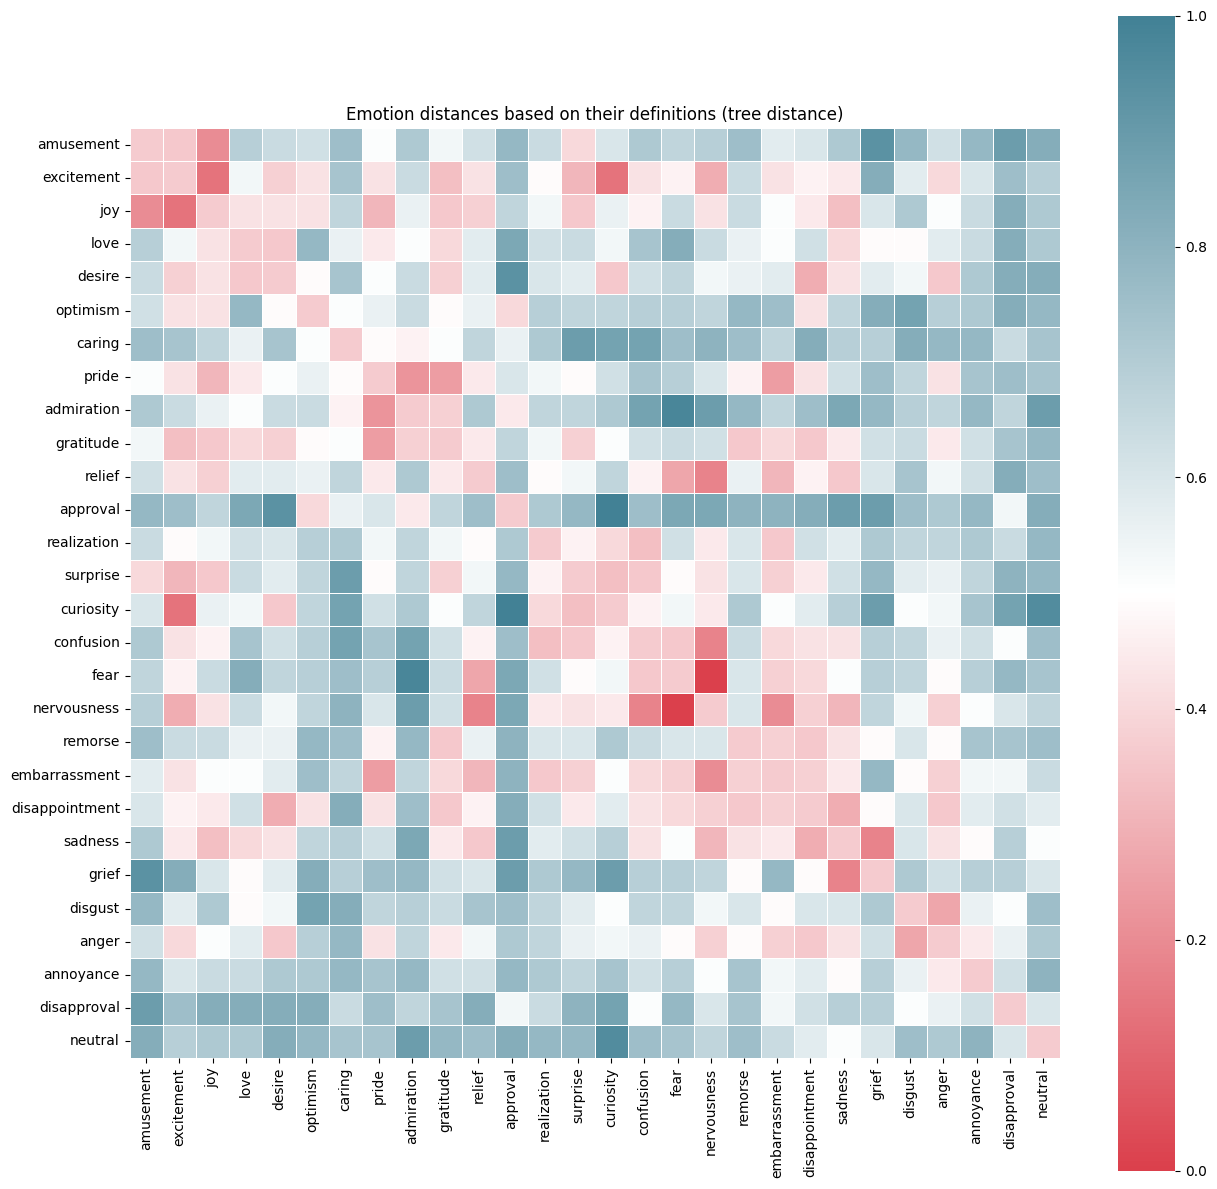

In [8]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()

# Embedding + Tree Distances

In [9]:
from emotion_tree import get_distance

distances_tree = np.zeros((len(emotions), len(emotions)))
for i, emotion1 in enumerate(emotions):
    for j, emotion2 in enumerate(emotions):
        distances_tree[i, j] = get_distance([emotion1], [emotion2])

#distances_tree[distances_tree < 0] = 0.5

In [10]:
import matplotlib as mpl
import seaborn as sns
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)

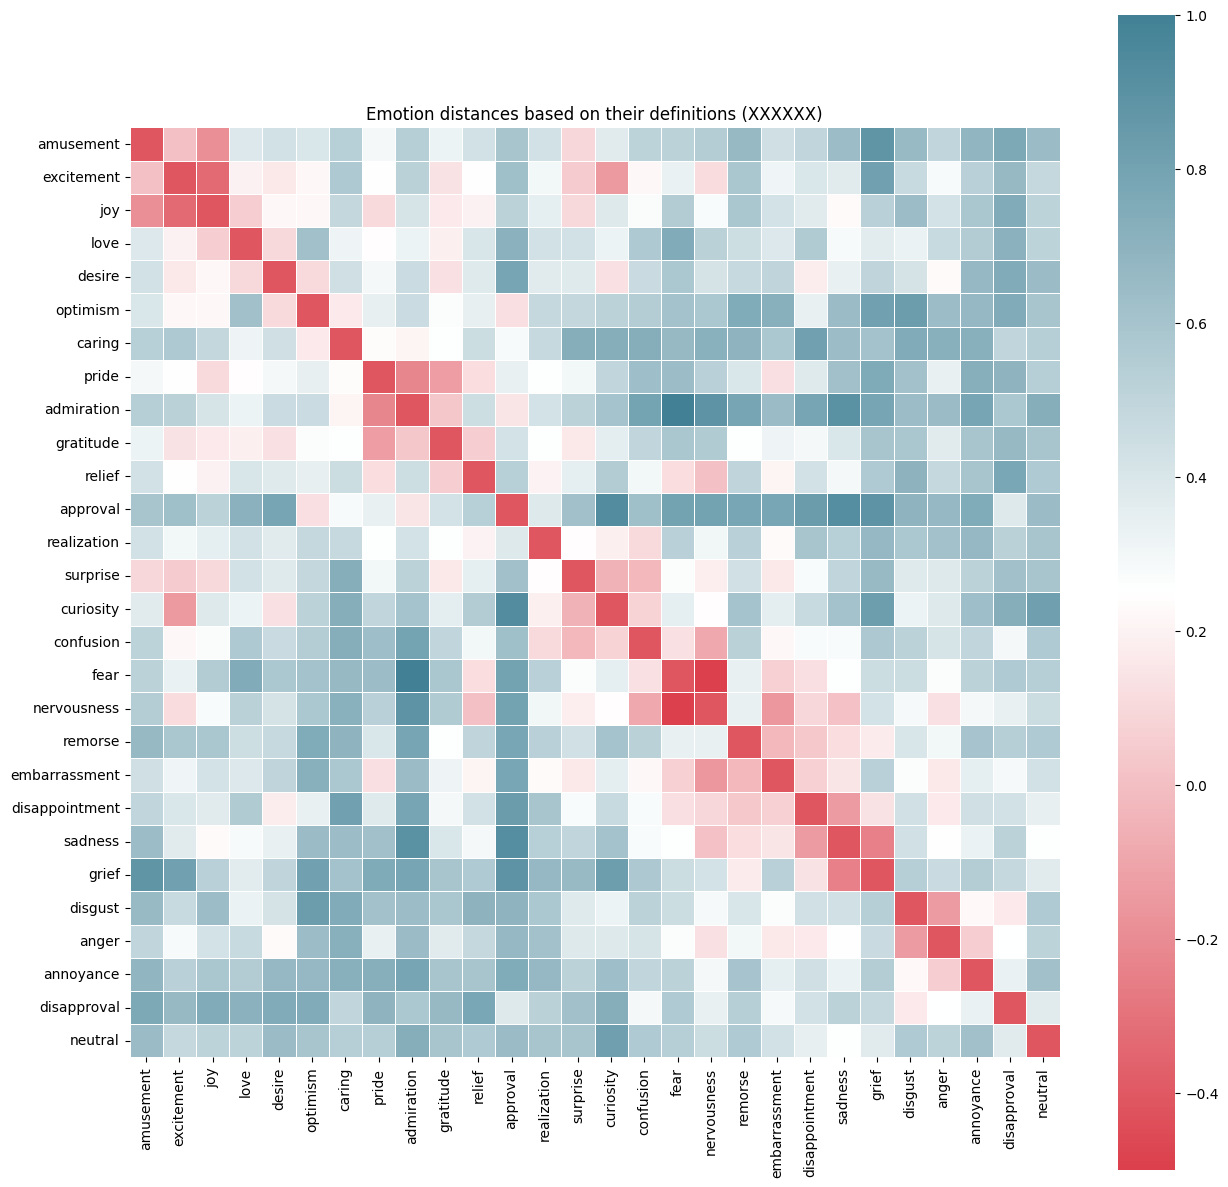

In [11]:
plt.figure(figsize=(15, 15))
beta = 0.25
combined = (distances_tree * beta) + (distances_embed * (1 - beta))
combined = (combined - combined.min()) / (combined.max() - combined.min())
combined = combined * 1.5 - 0.5 # scale values to be between -0.5 and 1


sns.heatmap(
    combined,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (XXXXXX)")
plt.show()

In [12]:
np.fill_diagonal(combined, -1) # set diagonal to -1

In [13]:
# make a dictionary of each emotions pair and their distance
emotion_pairs = {}
for i, emotion1 in enumerate(emotions):
    for j, emotion2 in enumerate(emotions):
        emotion_pairs[(emotion1, emotion2)] = combined[i, j]

# make it into a pd dataframe with column for emotion 1 and emotion 2 and distance
import pandas as pd
df = pd.DataFrame(emotion_pairs.items(), columns=['Emotion Pair', 'Distance'])
df['Emotion_1'] = df['Emotion Pair'].apply(lambda x: x[0])
df['Emotion_2'] = df['Emotion Pair'].apply(lambda x: x[1])
df = df.drop(columns=['Emotion Pair'])
df = df[['Emotion_1', 'Emotion_2', 'Distance']]
df = df.sort_values(by='Distance')
df = df.reset_index(drop=True)
# sace
df.to_csv('emotion_distances.csv', index=False)
